In [1]:
import os
import torch
import torch.nn as nn
from models import AEEncoder, AEDecoder, weights_init
import numpy as np
import h5py
from dataset import HRTFDataset, get_dataloaders
import global_params as gp
from utils import get_lsd, get_log_fft
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using %s" % device)

Using cuda


In [3]:
# Initialize global parameters
exp = "exp4"
ep = "_ep400000.pth"
whichHRIR = "raw"
valSubjs = [12, 29, 40]

if whichHRIR == "trunc64":
    nfft = 64
    anthroFlag = True
elif whichHRIR == "raw":
    nfft = 256
    anthroFlag = False

In [4]:
encoder = AEEncoder(inChannels=gp.inOutChannels, dsType=gp.encDSType, BNFlag=gp.encBNFlag,
                    modelDepth=gp.modelDepth, featMapsMultFact=gp.featMapsMultFact, numConvBlocks=gp.numConvBlocks,
                    dropoutP=0).to(device)
decoder = AEDecoder(outChannels=gp.inOutChannels, finalActType=gp.decFinalActType, BNFlag=gp.decBNFlag, 
                    modelDepth=gp.modelDepth, featMapsMultFact=gp.featMapsMultFact, numConvBlocks=gp.numConvBlocks,
                    outPadArray=gp.decOutPadArray, dropoutP=0).to(device)

checkpoint = torch.load("./saved_models/vae_"+exp+ep, map_location=device)
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

encoder.eval()
decoder.eval()

AEDecoder(
  (moduleDict): ModuleDict(
    (conv_first): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
    (tconv_2): ConvTranspose2d(64, 128, kernel_size=(2, 2), stride=(2, 2), output_padding=(0, 1), groups=8)
    (tconv_1): ConvTranspose2d(128, 256, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 0), groups=8)
    (final_conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
  )
  (firstConv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
  (tConvBlock): ConvTranspose2d(128, 256, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 0), groups=8)
  (finalConv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
  (finalAct): Sigmoid()
)

In [5]:
# Getting results on train dataset
# Get Data
dataPath = "../data/cipic_latest.hdf5"
datasetTrain = HRTFDataset(dataPath, whichHRIR=whichHRIR, 
                           trainValOp="train", valSubjs=valSubjs, anthroFlag=anthroFlag, 
                           azOps=gp.azOps, elOps=gp.elOps, samplingOp=gp.samplingOp, quadSelect=gp.quadSelect)
trainDL = get_dataloaders(datasetTrain, batchSize=datasetTrain.__len__(), shuffle=False)

for i, batch in enumerate(trainDL):
    inHRTF = batch["hrtf_l"].to(device)
    targetHRTF = inHRTF
    
    # forward pass
    predHRTF = decoder(encoder(inHRTF))


In [6]:
targetHRTF = targetHRTF.detach().cpu()
predHRTF = predHRTF.detach().cpu()
inHRTF = inHRTF.detach().cpu()

In [7]:
targetHRTF = 20*(targetHRTF - 1)*6
predHRTF = 20*(predHRTF - 1)*6
inHRTF = 20*(inHRTF - 1)*6
avgHRTF = torch.mean(targetHRTF, 0)
avgHRTFExpanded = avgHRTF.expand(targetHRTF.size()[0], targetHRTF.size()[1], 25, 50).clone()

In [8]:
lsdFreq = get_lsd(predHRTF, targetHRTF, "freq")
lsdFreqMean = torch.mean(lsdFreq, 0)

Text(0.5, 0, 'Frequency (Hz)')

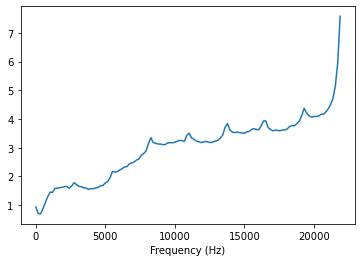

In [9]:
faxis = np.arange(nfft/2)*44100/nfft;
plt.plot(faxis, lsdFreqMean)
plt.xlabel("Frequency (Hz)")

In [10]:
lsd = get_lsd(predHRTF, targetHRTF)
lsdMean = torch.mean(lsd)
print("Mean LSD: %.4f" % lsdMean)

Mean LSD: 2.8442


Text(0.5, 1.0, 'LSD : Predicted v/s Target')

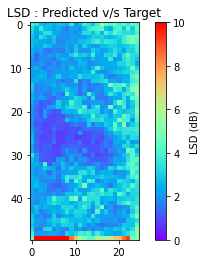

In [11]:
# Getting LSD plot
subj = 0
lsd2D = get_lsd(predHRTF, targetHRTF, mean_op="pos")
plt.imshow(lsd2D[subj].T, vmin=0, vmax=10, cmap='rainbow')
plt.colorbar(label="LSD (dB)", orientation="vertical")
plt.title("LSD : Predicted v/s Target")

In [12]:
lsd2D.size()

torch.Size([42, 25, 50])

Subject 6 LSD : 2.602


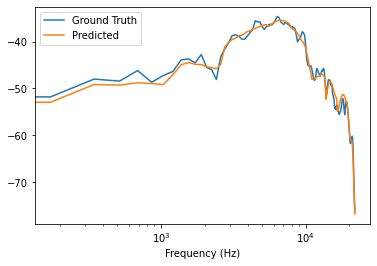

In [13]:
# Plotting hrtfs
subj = 6
az = 6
el = 18

thisLsd = lsd[subj]
print("Subject %d LSD : %.3f" % (subj, thisLsd))

thisTargetHrtf = targetHRTF[subj, :, az, el]
thisPredHrtf = predHRTF[subj, :, az, el]

faxis = np.arange(nfft/2)*44100/nfft;
plt.plot(faxis, thisTargetHrtf)
plt.plot(faxis, thisPredHrtf)
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.legend(["Ground Truth", "Predicted"])

In [14]:
# Getting results on Validation data

# Get Data
dataPath = "../data/cipic_latest.hdf5"
datasetVal = HRTFDataset(dataPath, whichHRIR=whichHRIR, 
                         trainValOp="val", valSubjs=valSubjs, anthroFlag=anthroFlag, 
                         azOps=gp.azOps, elOps=gp.elOps, samplingOp=gp.samplingOp, quadSelect=gp.quadSelect)
valDL = get_dataloaders(datasetVal, batchSize=datasetVal.__len__(), shuffle=False)

for i, batch in enumerate(valDL):
    inHRTF = batch["hrtf_l"].to(device)
    targetHRTF = batch["hrtf_l"].to(device)
    
    # forward pass
    predHRTF = decoder(encoder(inHRTF))


In [15]:
targetHRTF = targetHRTF.detach().cpu()
predHRTF = predHRTF.detach().cpu()
inHRTF = inHRTF.detach().cpu()

In [16]:
targetHRTF = 20*(targetHRTF - 1)*6
predHRTF = 20*(predHRTF - 1)*6
inHRTF = 20*(inHRTF - 1)*6
avgHRTFExpanded = avgHRTF.expand(targetHRTF.size()[0], targetHRTF.size()[1], 25, 50)

In [17]:
lsdFreq = get_lsd(predHRTF, targetHRTF, "freq")
lsdFreqMean = torch.mean(lsdFreq, 0)

Text(0.5, 0, 'Frequency (Hz)')

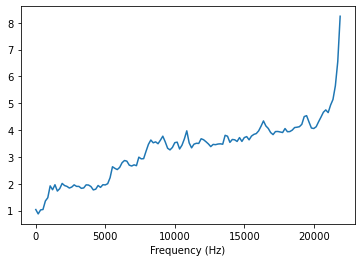

In [18]:
faxis = np.arange(nfft/2)*44100/nfft;
plt.plot(faxis, lsdFreqMean)
plt.xlabel("Frequency (Hz)")

In [19]:
lsd = get_lsd(predHRTF, targetHRTF)
lsdMean = torch.mean(lsd)
print("Mean LSD: %.5f" % lsdMean)

lsdAvg = get_lsd(avgHRTFExpanded, targetHRTF)
lsdAvgMean = torch.mean(lsdAvg)
print("Mean LSD: Average %.5f" % lsdAvgMean)

Mean LSD: 3.11428
Mean LSD: Average 4.93192


In [20]:
fMin = 0
fMax = 11000
lsdBL = get_lsd(predHRTF, targetHRTF, frange=[fMin, fMax])
lsdBLMean = torch.mean(lsdBL)
print("Mean Bandlimited LSD: %.3f" % lsdBLMean)

Mean Bandlimited LSD: 2.260


LSD for this subject: 2.89549


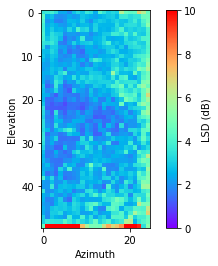

In [21]:
subj = 2
lsd2D = get_lsd(predHRTF, targetHRTF, mean_op="pos")
print("LSD for this subject: %.5f" % torch.mean(lsd2D[subj]))
plt.imshow(lsd2D[subj].T, vmin=0, vmax=10, cmap='rainbow')
plt.colorbar(label="LSD (dB)", orientation="vertical")
plt.xlabel("Azimuth")
plt.ylabel("Elevation")
#plt.title("LSD : CNN predicted v/s Input")
plt.rcParams.update({'font.size': 16})
#plt.savefig("../smc_figures/smc_interp_lsd_sp1_sub"+str(subj)+".pdf", bbox_inches="tight")

LSD for this subject: 4.76752


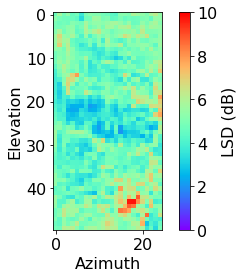

In [22]:
lsd2D = get_lsd(avgHRTFExpanded, targetHRTF, mean_op="pos")
print("LSD for this subject: %.5f" % torch.mean(lsd2D[subj]))
plt.imshow(lsd2D[subj].T, vmin=0, vmax=10, cmap='rainbow')
plt.colorbar(label="LSD (dB)", orientation="vertical")
plt.xlabel("Azimuth")
plt.ylabel("Elevation")
plt.rcParams.update({'font.size': 16})
#plt.title("LSD : Linearly Interpolated v/s Input")
#plt.savefig("../smc_figures/smc_avg_lsd_sp2_sub"+str(subj)+".pdf", bbox_inches="tight")

Subject 2 LSD : 2.895


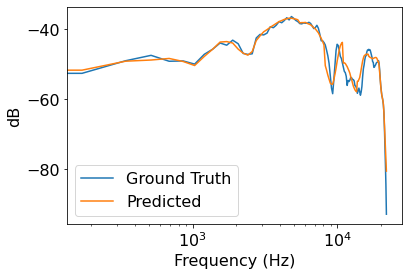

In [23]:
# Plotting hrtfs
subj = 2
az = 8
el = 14

thisLsd = lsd[subj]
print("Subject %d LSD : %.3f" % (subj, thisLsd))

thisTargetHrtf = targetHRTF[subj, :, az, el]
thisPredHrtf = predHRTF[subj, :, az, el]

faxis = np.arange(nfft/2)*44100/nfft;
plt.plot(faxis, thisTargetHrtf)
plt.plot(faxis, thisPredHrtf)
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB")
plt.legend(["Ground Truth", "Predicted"])
#plt.savefig("./plots/test_ae_hrtfs.png")